In [1]:
import crocoddyl
import mujoco
import mujoco.viewer
import mim_solvers
import numpy as np
import matplotlib.pyplot as plt
import hppfcl
import time
from os.path import dirname, join, abspath
np.set_printoptions(precision=4, linewidth=180)

import pin_utils, mpc_utils
import pinocchio as pin
from pinocchio.visualize import MeshcatVisualizer

from mim_robots.pybullet.env import BulletEnvWithGround
from mim_robots.robot_loader import load_bullet_wrapper, load_mujoco_model, get_robot_list, load_pinocchio_wrapper
from mim_robots.robot_list import MiM_Robots
from numpy.linalg import norm, solve
from scipy.spatial.transform import Rotation as R


pybullet build time: Nov 28 2023 23:45:17


In [2]:
# Robot simulator Mujoco
RobotInfo = MiM_Robots["iiwa"]
mj_model = load_mujoco_model("iiwa")
mj_data = mujoco.MjData(mj_model)
robot_simulator = load_pinocchio_wrapper("iiwa")
pin_model = robot_simulator.model
pin_collision_model = robot_simulator.collision_model
pin_visual_model = robot_simulator.visual_model
pin_data = pin_model.createData()
viz = MeshcatVisualizer(pin_model, pin_collision_model, pin_visual_model)



In [3]:
def create_obs(pos, rot, m, d, num_obs):
    obsPose = pin.SE3.Identity()
    obsPose.rotation = rot
    obsPose.translation = pos
    obsObj = pin.GeometryObject("obstacle"+str(num_obs),
                                m.getFrameId("universe"),
                                m.frames[pin_model.getFrameId("universe")].parent,
                                hppfcl.Box(d[0], d[1], d[2]),
                                obsPose)
    return obsObj

def convert_2_cart(states, frame_id):
    size = states.shape
    cart_pred = np.zeros(shape = (size[0], size[1], 3))
    dummy_robot = load_pinocchio_wrapper("iiwa")
    m = dummy_robot.model
    d = dummy_robot.data
    for cycle in range(size[0]):
        for t in range(size[1]):
            q = states[cycle,t,:m.nq]
            v = states[cycle,t,m.nq:]
            pin.forwardKinematics(m,d,q)
            pin.framesForwardKinematics(m, d, q)
            pin.updateFramePlacements(m, d)  
            p = d.oMf[frame_id].copy()
            cart_pred[cycle,t,:] = p.translation

    return cart_pred

In [4]:
# Robot simulator Mujoco
RobotInfo = MiM_Robots["iiwa"]
mj_model = load_mujoco_model("iiwa")
mj_data = mujoco.MjData(mj_model)
robot_simulator = load_pinocchio_wrapper("iiwa")
pin_model = robot_simulator.model
pin_collision_model = robot_simulator.collision_model
pin_visual_model = robot_simulator.visual_model
pin_data = pin_model.createData()

In [5]:
# Extract robot model
nq = robot_simulator.model.nq
nv = robot_simulator.model.nv
nu = nq; nx = nq+nv
q0 = np.array([0.1, 0.7, 0., 0.7, -0.5, 1.5, 0.])
v0 = np.zeros(nv)
p0 = np.array([0.35, -0.4, 0.4])
oMdes = pin.SE3.Identity()
oMdes.rotation = (R.from_euler('x', 180, degrees=True).as_matrix())
oMdes.translation = p0
idx = robot_simulator.index('A7')

In [6]:
eps    = 1e-4
IT_MAX = 1000
DT     = 1e0
damp   = 1e-6
# q = np.zeros(nq)
i = 1
while True:
    pin.forwardKinematics(pin_model,pin_data,q0)
    dMi = oMdes.actInv(pin_data.oMi[idx])
    err = pin.log(dMi).vector
    if norm(err) < eps:
        success = True
        break
    if i >= IT_MAX:
        success = False
        break
    J = pin.computeJointJacobian(pin_model,pin_data,q0,idx)
    v = - J.T.dot(solve(J.dot(J.T) + damp * np.eye(6), err))
    q0 = pin.integrate(pin_model,q0,v*DT)

pin.forwardKinematics(pin_model, pin_data, q0)
x0 = np.concatenate([q0, v0])
robot_simulator.forwardKinematics(q0, v0)
robot_simulator.computeJointJacobians(q0)
robot_simulator.framesForwardKinematics(q0)
robot_simulator.centroidalMomentum(q0, v0)

  f = 0 0 0
tau = 0 0 0

In [7]:
# Add robot to Mujoco and initialize
mj_renderer = mujoco.Renderer(mj_model)
mujoco.mj_step(mj_model, mj_data)
mj_renderer.update_scene(mj_data)
mj_data.qpos = q0
mj_data.qvel = v0
mujoco.mj_forward(mj_model, mj_data)
mj_dt=1e-3

In [8]:
# # # # # # # # # # # # # # #
###  SETUP CROCODDYL OCP  ###
# # # # # # # # # # # # # # #

# State and actuation model for MPC and IRL
stateMPC = crocoddyl.StateMultibody(pin_model)
stateIRL = crocoddyl.StateMultibody(pin_model)
actuationMPC = crocoddyl.ActuationModelFull(stateMPC)
actuationIRL = crocoddyl.ActuationModelFull(stateIRL)
# Running and terminal cost models for MPC and IRL
runningCostModelMPC = crocoddyl.CostModelSum(stateMPC)
runningCostModelIRL = crocoddyl.CostModelSum(stateIRL)
terminalCostModelMPC = crocoddyl.CostModelSum(stateMPC)
terminalCostModelIRL = crocoddyl.CostModelSum(stateIRL)

# Create cost terms 
# COLLISION COST 
# Create a capsule for the arm
link_names = ["A1", "A2", "A3", "A4", "A5", "A6", "A7"]
ig_link_names = []
# geomModel = pin.buildGeomFromUrdf(pin_model, MiM_Robots["iiwa"].urdf_path, pin.GeometryType.COLLISION, MiM_Robots["iiwa"].mesh_dir)
# geomModel.removeAllCollisionPairs()
pin_joint_ids = []
link_lengths = [0.36, 0, 0.42, 0, 0.4, 0, 0.126]
geomModel           = pin.GeometryModel() 
for i,ln in enumerate(link_names):
    pin_link_id         = pin_model.getFrameId(ln)
    pin_joint_id        = pin_model.getJointId(ln)
    pin_joint_ids.append(pin_joint_id)
    ig_link_names.append(geomModel.addGeometryObject(pin.GeometryObject("arm_link_"+str(i+1), 
                                                      pin_model.joints[pin_model.getJointId(ln)].id,
                                                      pin.SE3.Identity(),
                                                      hppfcl.Capsule(0.04, link_lengths[i]/2))))
    # ig_link_names.append(geomModel.addGeometryObject(pin.GeometryObject("arm_link_"+str(i), 
    #                                                   pin_link_id, 
    #                                                   pin_model.frames[pin_model.getFrameId(ln)].parentJoint,
    #                                                   hppfcl.Capsule(0, 0.5),
    #                                                   pin.SE3.Identity())))
    # if i > 0:
    #     geomModel.addCollisionPair(pin.CollisionPair(ig_link_names[i],ig_link_names[i-1]))
# print("num collision pairs - after addition:",len(geomModel.collisionPairs))

In [9]:
# Create obstacles in the world
obs_num = 3
obs_p = []
obs_p.append(np.array([0.450, -0.15, 0.4]))
obs_p.append(np.array([0.450, 0.0, 0.5]))
obs_p.append(np.array([0.450, 0.15, 0.6]))
for i,p in enumerate(obs_p):
    obsObj = create_obs(p, pin.SE3.Identity().rotation, pin_model, [0.1]*3, i)
    ig_obs = geomModel.addGeometryObject(obsObj)
    for j in ig_link_names[6:]:
        geomModel.addCollisionPair(pin.CollisionPair(ig_obs, ig_link_names[j])) # Mine
        # geomModel.addCollisionPair(pin.CollisionPair(ig_link_names[j],ig_obs)) # Original


print("num collision pairs - after obstacles:",len(geomModel.collisionPairs))

num collision pairs - after obstacles: 3


/tmp/ipykernel_71510/628141677.py:7: UserWarning: Deprecated member. Use Frame.parentJoint instead.
  m.frames[pin_model.getFrameId("universe")].parent,
/tmp/ipykernel_71510/628141677.py:5: UserWarning: This function has been marked as deprecated and will be removed in a future release.
  obsObj = pin.GeometryObject("obstacle"+str(num_obs),


In [10]:
########################
##### Cost for MPC #####
########################
# Data collectors
dataCollectorActMPC = crocoddyl.DataCollectorActMultibody(pin_data, crocoddyl.ActuationDataAbstract(actuationMPC))
dataCollectorStateMPC = crocoddyl.DataCollectorMultibody(pin_data)
dataCollectorTranslationMPC = crocoddyl.DataCollectorMultibody(pin_data)
dataCollectorCollisionMPC = crocoddyl.DataCollectorMultibody(pin_data)
# Control regularization cost
uResidualMPC = crocoddyl.ResidualModelControlGrav(stateMPC)
uRegCostMPC = crocoddyl.CostModelResidual(stateMPC, uResidualMPC)
uCostDataMPC = uRegCostMPC.createData(dataCollectorActMPC)
# State regularization cost
xResidualMPC = crocoddyl.ResidualModelState(stateMPC, x0)
xRegCostMPC = crocoddyl.CostModelResidual(stateMPC, xResidualMPC)
xCostDataMPC = xRegCostMPC.createData(dataCollectorStateMPC)
# endeff frame translation cost
endeff_frame_id = pin_model.getFrameId("contact")
endeff_joint_id = pin_model.getJointId("contact")
endeff_translation = pin_data.oMf[endeff_frame_id].translation.copy()
# endeff_translation = np.array([-0.4, 0.3, 0.7]) # move endeff +10 cm along x in WORLD frame
endeff_translation = np.array([0.45, 0.4, 0.6])
frameTranslationResidualMPC = crocoddyl.ResidualModelFrameTranslation(stateMPC, endeff_frame_id, endeff_translation)
frameTranslationCostMPC = crocoddyl.CostModelResidual(stateMPC, frameTranslationResidualMPC)
translationCostDataMPC = frameTranslationCostMPC.createData(dataCollectorTranslationMPC)

In [11]:
########################
##### Cost for IRL #####
########################
# Data collectors
dataCollectorActIRL = crocoddyl.DataCollectorActMultibody(pin_data, crocoddyl.ActuationDataAbstract(actuationIRL))
dataCollectorStateIRL = crocoddyl.DataCollectorMultibody(pin_data)
dataCollectorTranslationIRL = crocoddyl.DataCollectorMultibody(pin_data)
dataCollectorCollisionIRL = crocoddyl.DataCollectorMultibody(pin_data)
# Control regularization cost
uResidualIRL = crocoddyl.ResidualModelControlGrav(stateIRL)
uRegCostIRL = crocoddyl.CostModelResidual(stateIRL, uResidualIRL)
uCostDataIRL = uRegCostIRL.createData(dataCollectorActIRL)
# State regularization cost
xResidualIRL = crocoddyl.ResidualModelState(stateIRL, x0)
xRegCostIRL = crocoddyl.CostModelResidual(stateIRL, xResidualIRL)
xCostDataIRL = xRegCostIRL.createData(dataCollectorStateIRL)
# endeff frame translation cost
endeff_frame_id = pin_model.getFrameId("contact")
endeff_joint_id = pin_model.getJointId("contact")
endeff_translation = pin_data.oMf[endeff_frame_id].translation.copy()
# endeff_translation = np.array([-0.4, 0.3, 0.7]) # move endeff +10 cm along x in WORLD frame
endeff_translation = np.array([0.45, 0.4, 0.6])
frameTranslationResidualIRL = crocoddyl.ResidualModelFrameTranslation(stateIRL, endeff_frame_id, endeff_translation)
frameTranslationCostIRL = crocoddyl.CostModelResidual(stateIRL, frameTranslationResidualIRL)
translationCostDataIRL = frameTranslationCostIRL.createData(dataCollectorTranslationIRL)

In [12]:
# Weights (Shared in MPC and IRL)
w_running = {}
w_terminal = {}
w_running['stateReg'] = 1e-1
w_running['ctrlRegGrav'] = 1e-4
w_running['translation'] = 1e-1
w_terminal['stateReg'] = 1e-1
w_terminal['translation'] = 1e1

# Building Cost Function for MPC
runningCostModelMPC.addCost("running_stateReg", xRegCostMPC, w_running['stateReg'])
runningCostModelMPC.addCost("running_ctrlRegGrav", uRegCostMPC, w_running['ctrlRegGrav'])
runningCostModelMPC.addCost("running_translation", frameTranslationCostMPC, w_running['translation'])
terminalCostModelMPC.addCost("terminal_stateReg", xRegCostMPC, w_terminal['stateReg'])
terminalCostModelMPC.addCost("terminal_translation", frameTranslationCostMPC, w_terminal['translation'])

# Building Cost Function for IRL
runningCostModelIRL.addCost("running_stateReg", xRegCostIRL, w_running['stateReg'])
runningCostModelIRL.addCost("running_ctrlRegGrav", uRegCostIRL, w_running['ctrlRegGrav'])
runningCostModelIRL.addCost("running_translation", frameTranslationCostIRL, w_running['translation'])
terminalCostModelIRL.addCost("terminal_stateReg", xRegCostIRL, w_terminal['stateReg'])
terminalCostModelIRL.addCost("terminal_translation", frameTranslationCostIRL, w_terminal['translation'])

In [13]:
geomModel.collisionPairs.tolist()

[collision pair (7,6), collision pair (8,6), collision pair (9,6)]

In [14]:
collision_radius = 0.1

# Add collision cost to the MPC and IRL 
activationCollisionMPC = crocoddyl.ActivationModel2NormBarrier(3, collision_radius)
activationCollisionIRL = crocoddyl.ActivationModel2NormBarrier(3, collision_radius)

collisionPairCostDataMPC = []
residualCollisionMPC = []
costCollisionMPC = []

collisionPairCostDataIRL = []
residualCollisionIRL = []
costCollisionIRL = []

c = 0
for i in range(len(geomModel.collisionPairs)):
    # Adding Weights for Collision
    w_running['collision'+str(c)] = 100
    w_terminal['collision'+str(c)] = 100
    # MPC Collision Cost
    residualCollisionMPC.append(crocoddyl.ResidualModelPairCollision(stateMPC, nu, geomModel, i, pin_joint_ids[-1]))
    costCollisionMPC.append(crocoddyl.CostModelResidual(stateMPC, activationCollisionMPC, residualCollisionMPC[i]))
    collisionPairCostDataMPC.append(costCollisionMPC[i].createData(dataCollectorCollisionMPC))
    runningCostModelMPC.addCost("collision"+str(c), costCollisionMPC[i], w_running['collision'+str(c)])
    terminalCostModelMPC.addCost("collision"+str(c), costCollisionMPC[i], w_terminal['collision'+str(c)])
    # IRL Collision Cost
    residualCollisionIRL.append(crocoddyl.ResidualModelPairCollision(stateIRL, nu, geomModel, i, pin_joint_ids[-1]))
    costCollisionIRL.append(crocoddyl.CostModelResidual(stateIRL, activationCollisionIRL, residualCollisionIRL[i]))
    collisionPairCostDataIRL.append(costCollisionIRL[i].createData(dataCollectorCollisionIRL))
    runningCostModelIRL.addCost("collision"+str(c), costCollisionIRL[i], w_running['collision'+str(c)])
    terminalCostModelIRL.addCost("collision"+str(c), costCollisionIRL[i], w_terminal['collision'+str(c)])
    c=c+1

In [15]:
u0 = np.zeros(shape=(nu))

xRegCostMPC.calc(xCostDataMPC, x0, u0)
xRegCostMPC.calcDiff(xCostDataMPC, x0, u0)

uRegCostMPC.calc(uCostDataMPC, x0, u0)
uRegCostMPC.calcDiff(uCostDataMPC, x0, u0)

frameTranslationCostMPC.calc(translationCostDataMPC, x0, u0)
frameTranslationCostMPC.calcDiff(translationCostDataMPC, x0, u0)

for CostModel, CostData in zip(costCollisionMPC, collisionPairCostDataMPC):
    CostModel.calc(CostData, x0, u0)
    CostModel.calcDiff(CostData, x0, u0)

In [16]:
u0 = np.zeros(shape=(nu))
# x0_irl_test = np.zeros(shape=(nx))
x0_irl_test = x0

xRegCostIRL.calc(xCostDataIRL, x0_irl_test, u0)
xRegCostIRL.calcDiff(xCostDataIRL, x0_irl_test, u0)

uRegCostIRL.calc(uCostDataIRL, x0_irl_test, u0)
uRegCostIRL.calcDiff(uCostDataIRL, x0_irl_test, u0)

frameTranslationCostIRL.calc(translationCostDataIRL, x0_irl_test, u0)
frameTranslationCostIRL.calcDiff(translationCostDataIRL, x0_irl_test, u0)

for CostModel, CostData in zip(costCollisionIRL, collisionPairCostDataIRL):
    CostModel.calc(CostData, x0_irl_test, u0)
    CostModel.calcDiff(CostData, x0_irl_test, u0)

In [17]:
for i in range(len(collisionPairCostDataMPC)):
    costCollisionMPC[i].activation.alpha = 1

for CostModel, CostData in zip(costCollisionMPC, collisionPairCostDataMPC):
    CostModel.calc(CostData, x0)
    CostModel.calcDiff(CostData, x0)

In [18]:
# Weightless Collision Cost Computation Validation for MPC model
for i in range(len(collisionPairCostDataMPC)):
    r_norm = np.linalg.norm(collisionPairCostDataMPC[i].residual.r)
    if r_norm > costCollisionMPC[i].activation.alpha:
        difference = 0
    else:
        difference = r_norm-costCollisionMPC[i].activation.alpha
    print('Cost: ', collisionPairCostDataMPC[i].cost, '|| My Cost: ', 0.5*(difference)*(difference))

Cost:  0.3476548062270449 || My Cost:  0.3476548062270449
Cost:  0.23527753941166576 || My Cost:  0.23527753941166576
Cost:  0.1371459527254263 || My Cost:  0.1371459527254263


In [19]:
# Weightless State Regulation Cost Computation Validation
r = xCostDataMPC.residual.r
print('Cost: ', xCostDataMPC.cost, '|| My Cost: ', 0.5*(r).T@(r))

Cost:  0.0 || My Cost:  0.0


In [20]:
uRegCostMPC.calc(uCostDataMPC, x0, u0)
uRegCostMPC.calcDiff(uCostDataMPC, x0, u0)

In [21]:
# Weightless Gravity Comp Regulation Cost Computation Validation
r = uCostDataMPC.residual.r
print('Cost: ', uCostDataMPC.cost, '|| My Cost: ', 0.5*(r).T@(r))

Cost:  1254.0099648366177 || My Cost:  1254.0099648366177


In [22]:
# Weightless Translation Cost Computation Validation
r = translationCostDataMPC.residual.r
print('Cost: ', translationCostDataMPC.cost, '|| My Cost: ', 0.5*(r).T@(r))

Cost:  0.3537951641264794 || My Cost:  0.3537951641264794


In [23]:
# Create Differential Action Model (DAM), i.e. continuous dynamics and cost functions
running_DAMMPC = crocoddyl.DifferentialActionModelFreeFwdDynamics(stateMPC, actuationMPC, runningCostModelMPC)
terminal_DAMMPC = crocoddyl.DifferentialActionModelFreeFwdDynamics(stateMPC, actuationMPC, terminalCostModelMPC)

# Create Differential Action Model (DAM), i.e. continuous dynamics and cost functions
running_DAMIRL = crocoddyl.DifferentialActionModelFreeFwdDynamics(stateIRL, actuationIRL, runningCostModelIRL)
terminal_DAMIRL = crocoddyl.DifferentialActionModelFreeFwdDynamics(stateIRL, actuationIRL, terminalCostModelIRL)

In [24]:
dt = 1e-2

# Create Integrated Action Model (IAM), i.e. Euler integration of continuous dynamics and cost
runningModelMPC = crocoddyl.IntegratedActionModelEuler(running_DAMMPC, dt)
terminalModelMPC = crocoddyl.IntegratedActionModelEuler(terminal_DAMMPC, 0.)
runningModelMPC.differential.armature = np.array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.])
terminalModelMPC.differential.armature = np.array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.])

# Create Integrated Action Model (IAM), i.e. Euler integration of continuous dynamics and cost
runningModelIRL = crocoddyl.IntegratedActionModelEuler(running_DAMIRL, dt)
terminalModelIRL = crocoddyl.IntegratedActionModelEuler(terminal_DAMIRL, 0.)
runningModelIRL.differential.armature = np.array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.])
terminalModelIRL.differential.armature = np.array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.])

In [25]:
# Create the shooting problem
T = 50
problem = crocoddyl.ShootingProblem(x0, [runningModelMPC] * T, terminalModelMPC)

# Create solver + callbacks
solver = mim_solvers.SolverSQP(problem)
solver.setCallbacks([crocoddyl.CallbackLogger(),
                  crocoddyl.CallbackVerbose()])
# Warm start : initial state + gravity compensation
xs_init = [x0 for i in range(T+1)]
us_init = solver.problem.quasiStatic(xs_init[:-1])
# Solve
solver.termination_tolerance = 1e-4
solver.with_callbacks = True
solver.solve(xs_init, us_init, 100)
solver.with_callbacks = False

iter     merit         cost         grad      step    ||gaps||        KKT
   1  1.11567e+02  1.11567e+02  3.91320e+02  1.0000  0.00000e+00  8.74326e+01
   2  2.75514e+02  5.37482e+01  5.43177e+02  0.2500  2.21765e+02  1.80864e+01
   3  2.32631e+02  7.25677e+01  5.70761e+02  1.0000  1.60063e+02  3.24818e+01
   4  6.22717e+02  6.95854e+01  7.53591e+02  0.2500  5.53131e+02  3.29399e+01
   5  4.94045e+02  1.12885e+02  8.70151e+02  1.0000  3.81161e+02  3.09341e+01
   6  1.12444e+03  5.51637e+01  1.02051e+03  1.0000  1.06928e+03  3.04983e+01
   7  7.61319e+02  1.42368e+02  1.10824e+03  1.0000  6.18951e+02  8.77712e+01
   8  1.97243e+03  1.12523e+02  1.23331e+03  1.0000  1.85991e+03  6.06322e+01
   9  1.58279e+03  4.93812e+01  7.57818e+02  1.0000  1.53341e+03  4.61799e+01
  10  7.63747e+02  8.84293e+01  8.03929e+02  0.5000  6.75318e+02  3.89998e+01
iter     merit         cost         grad      step    ||gaps||        KKT
  11  7.29815e+02  1.78073e+02  9.68505e+02  1.0000  5.51742e+02  5.9349

In [106]:
# Creat dummy problem 
T = 1
dummys = []
dummy_problem = crocoddyl.ShootingProblem(x0, [runningModelIRL] * T, terminalModelIRL)
dummy_solver = mim_solvers.SolverSQP(dummy_problem)
dummys = [dummy_solver] * 3
for i in range(2):
    dummys[i].setCallbacks([crocoddyl.CallbackLogger(),
                      crocoddyl.CallbackVerbose()])
    # Warm start : initial state + gravity compensation
    xs_init = [x0 for i in range(T+1)]
    us_init = dummys[i].problem.quasiStatic(xs_init[:-1])
    # Solve
    dummys[i].termination_tolerance = 1e-4
    dummys[i].with_callbacks = True
    dummys[i].solve(xs_init, us_init, 100)

iter     merit         cost         grad      step    ||gaps||        KKT
   1  3.53831e+00  3.53831e+00  1.32263e+02  1.0000  0.00000e+00  1.72469e-02
 END  3.53143e+00  3.53143e+00  1.70801e-01   ----   1.56721e-16  3.69985e-05
iter     merit         cost         grad      step    ||gaps||        KKT
   1  3.53831e+00  3.53831e+00  1.32263e+02  1.0000  0.00000e+00  1.72469e-02
 END  3.53143e+00  3.53143e+00  1.70801e-01   ----   1.56721e-16  3.69985e-05


In [107]:
w_terminal

{'stateReg': 0.1,
 'translation': 10.0,
 'collision0': 100,
 'collision1': 100,
 'collision2': 100}

In [77]:
print(dummy_solver.problem.terminalData.differential.costs.costs['terminal_translation'].cost*w_terminal['translation']+
      dummy_solver.problem.terminalData.differential.costs.costs['terminal_stateReg'].cost*w_terminal['stateReg'])

3.528461636576888


In [152]:
dummys[0].xs.tolist()

[array([-1.6017,  0.8571,  1.1475, -1.6879, -0.8432,  1.1758,  2.9158,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ]),
 array([-1.6004e+00,  8.5690e-01,  1.1493e+00, -1.6896e+00, -8.4229e-01,  1.1759e+00,  2.9158e+00,  1.2923e-01, -2.1226e-02,  1.7192e-01, -1.7247e-01,  9.0386e-02,  1.0914e-02,
         2.8419e-04])]

In [386]:
numerical_cost = 0

# Running Model Cost
x_irl = dummys[0].xs.tolist()[0]
u_irl = dummys[0].us.tolist()[0]

xRegCostIRL.calc(xCostDataIRL, x_irl, u_irl)
xRegCostIRL.calcDiff(xCostDataIRL, x_irl, u_irl)

uRegCostIRL.calc(uCostDataIRL, x_irl, u_irl)
uRegCostIRL.calcDiff(uCostDataIRL, x_irl, u_irl)

frameTranslationCostIRL.calc(translationCostDataIRL, x_irl, u_irl)
frameTranslationCostIRL.calcDiff(translationCostDataIRL, x_irl, u_irl)

for CostModel, CostData in zip(costCollisionIRL, collisionPairCostDataIRL):
    CostModel.calc(CostData, x_irl, u_irl)
    CostModel.calcDiff(CostData, x_irl, u_irl)


print(np.linalg.norm(translationCostDataIRL.residual.r))
print(0.5*np.linalg.norm(translationCostDataIRL.residual.r)*np.linalg.norm(translationCostDataIRL.residual.r))
print(translationCostDataIRL.cost)
print()
numerical_cost += xCostDataIRL.cost * w_running['stateReg'] 
numerical_cost += uCostDataIRL.cost * w_running['ctrlRegGrav'] 
numerical_cost += translationCostDataIRL.cost * w_running['translation'] 
numerical_cost += collisionPairCostDataIRL[0].cost * w_running['collision0'] 
numerical_cost += collisionPairCostDataIRL[1].cost * w_running['collision1'] 
numerical_cost += collisionPairCostDataIRL[2].cost * w_running['collision2'] 
numerical_cost *= 0.01

# Terminal Model Cost
x_irl = dummys[0].xs.tolist()[1]

xRegCostIRL.calc(xCostDataIRL, x_irl)
xRegCostIRL.calcDiff(xCostDataIRL, x_irl)

frameTranslationCostIRL.calc(translationCostDataIRL, x_irl)
frameTranslationCostIRL.calcDiff(translationCostDataIRL, x_irl)

for CostModel, CostData in zip(costCollisionIRL, collisionPairCostDataIRL):
    CostModel.calc(CostData, x_irl)
    CostModel.calcDiff(CostData, x_irl)
    
print(np.linalg.norm(translationCostDataIRL.residual.r))
print(0.5*np.linalg.norm(translationCostDataIRL.residual.r)*np.linalg.norm(translationCostDataIRL.residual.r))
print(translationCostDataIRL.cost)
numerical_cost += xCostDataIRL.cost * w_terminal['stateReg']
numerical_cost += translationCostDataIRL.cost * w_terminal['translation']
numerical_cost += collisionPairCostDataIRL[0].cost * w_terminal['collision0']
numerical_cost += collisionPairCostDataIRL[1].cost * w_terminal['collision1'] 
numerical_cost += collisionPairCostDataIRL[2].cost * w_terminal['collision2']



0.8395503598248722
0.35242240334103625
0.35242240334103625

0.8411838849222913
0.3537951641264793
0.3537951641264794


In [307]:
x_irl = dummys[0].xs.tolist()[0]
print(x_irl)
frameTranslationCostIRL.calc(translationCostDataIRL, x_irl)
frameTranslationCostIRL.calcDiff(translationCostDataIRL, x_irl)
# translationCostDataIRL.residual.r
frameTranslationCostIRL.residual.reference

[-1.6017  0.8571  1.1475 -1.6879 -0.8432  1.1758  2.9158  0.      0.      0.      0.      0.      0.      0.    ]


array([0.45, 0.4 , 0.6 ])

In [387]:
# Numerical Check for Cost computation:
final_cost = 0
for cost_model, cost_data in zip(dummys[0].problem.runningModels, dummys[0].problem.runningDatas):
    for cost_feat in cost_model.differential.costs.costs.todict():
        final_cost += cost_data.differential.costs.costs[cost_feat].cost*cost_model.differential.costs.costs[cost_feat].weight * dt

for cost_feat in dummys[0].problem.terminalModel.differential.costs.costs.todict():
        final_cost += dummys[0].problem.terminalData.differential.costs.costs[cost_feat].cost*dummys[0].problem.terminalModel.differential.costs.costs[cost_feat].weight


print('Solver Cost: ', dummy_solver.cost , '|| Computed Sum Cost: ', final_cost, '|| Numerical Cost: ', numerical_cost)    
    

Solver Cost:  3.5314291764761934 || Computed Sum Cost:  3.5314291764761934 || Numerical Cost:  3.543795676799497


In [396]:
A = dummys[0].problem.terminalData.differential.copy().cost
A = 2
dummys[0].problem.terminalData.differential.cost

3.528461636576888

In [46]:
# # # # # # # # # # # #
###  MPC SIMULATION ###
# # # # # # # # # # # #
# OCP parameters
ocp_params = {}
ocp_params['N_h']          = T
ocp_params['dt']           = dt
ocp_params['maxiter']      = 10 
ocp_params['nbody']        = 1
ocp_params['pin_model']    = robot_simulator.model
ocp_params['armature']     = runningModel.differential.armature
ocp_params['id_endeff']    = endeff_frame_id
ocp_params['active_costs'] = solver.problem.runningModels[0].differential.costs.active.tolist()

# Simu parameters
sim_params = {}
# sim_params['sim_freq']  = int(1./env.dt)
sim_params['sim_freq']  = int(1./mj_dt)
sim_params['mpc_freq']  = 1000
sim_params['T_sim']     = 1.0
log_rate = 100

# Initialize simulation data 
sim_data = mpc_utils.init_sim_data(sim_params, ocp_params, x0)


                       *************************
                       ** Simulation is ready **
                       *************************
-------------------------------------------------------------------
- Total simulation duration            : T_sim           = 1.0 s
- Simulation frequency                 : f_simu          = 1.0 kHz
- Replanning frequency                 : f_plan          = 1.0 kHz
- Total # of simulation steps          : N_sim           = 1000
- Total # of planning steps            : N_mpc           = 1000
- Duration of MPC horizon              : T_ocp           = 0.5 s
- OCP integration step                 : dt              = 0.01 s
-------------------------------------------------------------------



/tmp/ipykernel_17269/3489792870.py:13: UserWarning: Deprecated. Use property active_set
  ocp_params['active_costs'] = solver.problem.runningModels[0].differential.costs.active.tolist()


In [47]:
# Correction Setup
apply_correction = False
correction = np.zeros(shape=(sim_data['N_sim']+1,pin_model.nq))
correction_joints = [1,3,5]
correction_torque = 35
corr_t_start = 100 # At which timestamp correction starts
corr_t_end = 800 # At which timestamp correction ends
if apply_correction:
    correction[corr_t_start:corr_t_end,correction_joints] = correction_torque

In [45]:
def check_perturb(viewer):
    if viewer.perturb.active:
        return True
    else:
        return False

def update_weights(model, data, w, problem, sample_traj_set, corrected_traj):
    new_w = w
    return w

def update_solver_weights(solver, w):
    for i in solver.problem.runningModels:
        for j in i.differential.costs.costs.todict().keys():
            i.differential.costs.costs[j].weight = w[j]
    for j in solver.problem.terminalModel.differential.costs.costs.todict().keys():
        solver.problem.terminalModel.differential.costs.costs[j].weight = w[j]
    return True

class CostModel():
    def __init__(self, x, u, x_cost, u_cost, t_cost, c_cost):
        self.x = x
        self.u = u
        self.ccost_model = c_cost
        self.ucost_model = u_cost
        self.xcost_model = x_cost
        self.tcost_model = t_cost
        # self.ccost = np.zeros(shape=(len(c_cost)))
        self.ccost = 0.0
        self.xcost = 0.0
        self.ucost = 0.0
        self.tcost = 0.0
        
    def getXcost(self, x, u):
        self.xcost_model.calc(self.xcost_data, x, u)
        self.xcost_model.calcDiff(self.xcost_data, x, u)
        self.xcost = self.xcost_data.copy().cost
        return self.xcost

    def getTcost(self, x, u):
        self.tcost_model.calc(self.tcost_data, x, u)
        self.tcost_model.calcDiff(self.tcost_data, x, u)
        self.tcost = self.tcost_data.copy().cost
        return self.tcost
        
    def getUcost(self, x, u):
        # if u is None:
        #     self.ucost_model.calc(self.ucost_data, x)
        #     self.ucost_model.calcDiff(self.ucost_data, x)
        #     self.ucost = self.ucost_data.copy().cost
        # else: 
        self.ucost_model.calc(self.ucost_data, x, u)
        self.ucost_model.calcDiff(self.ucost_data, x, u)
        self.ucost = self.ucost_data.copy().cost
        return self.ucost
        
    def getCcost(self, x, u):
        c = 0
        for CostModel, CostData in zip(self.ccost_model, self.ccost_data):
            CostModel.calc(CostData, x, u)
            CostModel.calcDiff(CostData, x, u)
            self.ccost[c] = CostData.copy().cost
            c = c + 1
        return self.ccost

    # def getCcost(self, x, u):
    #     self.ccost_model.calc(self.ccost_data, x, u)
    #     self.ccost_model.calcDiff(self.ccost_data, x, u)
    #     self.ccost = self.ccost_data.copy().cost
    #     return self.ccost
        
    def getAll(self,x,u):
        self.xcost = self.getXcost(x, u)
        self.ucost = self.getUcost(x, u)
        self.ccost = self.getCcost(x, u)
        self.tcost = self.getTcost(x, u)

class CostStack():
    def __init__(self,cost_model, cost_data, cost_weight):
        self.w = weight
        self.m = cost_model
        self.d = cost_data
        try:
            self.c = np.zeros(shape=(len(cost_data)))
        except:
            self.c = 0.0

X_costIRL = CostStack(xRegCostIRL, xCostDataIRL, w_running['stateReg'])
U_costIRL = CostStack(uRegCostIRL, uCostDataIRL, w_running['ctrlRegGrav'])
T_costIRL = CostStack(frameTranslationCostIRL, translationCostDataIRL, w_running['translation'])
C_costIRL = []
for i in range(len(collisionPairCostDataIRL)):
    C_costIRL.append(CostStack(costCollisionIRL[i], collisionPairCostDataIRL[i], w_running['collision'+str(i)]))


Cost = CostModel(x0, np.zeros(shape=(nu)), 
                 xRegCost.copy(), xCostData.copy(), 
                 uRegCost.copy(), uCostData.copy(), 
                 frameTranslationCost.copy(), translationCostData.copy(),
                 costCollision.copy(), collisionPairCostData.copy())

NameError: name 'xRegCost' is not defined

In [142]:
# Cost.getAll(x_ref_SIM_RATE, u_ref_SIM_RATE)
Cost.ccost_model.activation.alpha = 1.3
# costCollision[1].activation.alpha = 1.3
# costCollision[2].activation.alpha = 0.3
Cost.getAll(solver.xs.tolist()[0], solver.us.tolist()[0])
# running_w
print('Translation Cost :', Cost.tcost)
print('Gravity Comp Cost :', Cost.ucost)
print('State Regulation Cost :', Cost.xcost)
print('Collision Cost :', Cost.ccost)

Translation Cost : 0.3537951641264794
Gravity Comp Cost : 1254.0099648366177
State Regulation Cost : 0.0
Collision Cost : 0.6428104090360227


In [24]:
# Display target 
mj_data.qpos = q0
mj_data.qvel = np.zeros(sim_data['nq'])
# mpc_utils.display_ball(endeff_translation, RADIUS=.05, COLOR=[1.,0.,0.,.6])
Mujoco_view = True
if Mujoco_view:
    viewer = mujoco.viewer.launch_passive(mj_model, mj_data, show_left_ui=True, show_right_ui=True)
    viewer.user_scn.flags[mujoco.mjtRndFlag.mjRND_WIREFRAME] = 1
    viewer.user_scn.ngeom = obs_num+1
    for i,p in enumerate(obs_p):
        mujoco.mjv_initGeom(
                viewer.user_scn.geoms[i],
                type=mujoco.mjtGeom.mjGEOM_BOX,
                size=[0.05, 0.05, 0.05],
                pos=p,
                mat=np.eye(3).flatten(),
                rgba=np.array([1.,0.,0.,.5])
            )
    
    mujoco.mjv_initGeom(
              viewer.user_scn.geoms[viewer.user_scn.ngeom-1],
              type=mujoco.mjtGeom.mjGEOM_SPHERE,
              size=[0.05, 0.05, 0.05],
              pos=endeff_translation,
              mat=np.eye(3).flatten(),
              rgba=np.array([0.,1.,0.,.5])
          )
    viewer.sync()

In [112]:
solver.problem.runningDatas[-1].differential.costs.costs['running_translation'].residual.r

array([-6.6655e-02, -4.7502e-02,  9.8563e-05])

In [111]:
translationCostData.residual.r

array([-6.6655e-02, -4.7502e-02,  9.8563e-05])

In [115]:
xwcost = 0
twcost = 0
uwcost = 0
cwcost = 0

for xs, us in zip(solver.xs.tolist(), solver.us.tolist()):
    Cost.getAll(xs, us)
    xwcost += w['running_stateReg']*Cost.xcost
    twcost += w['running_translation']*Cost.tcost
    uwcost += w['running_ctrlRegGrav']*Cost.ucost
    cwcost += np.sum(w['collision0']*Cost.ccost)
print((xwcost + twcost + uwcost + cwcost)/T)
print(solver.cost)

0.7912040625911376
0.5524590154356199


In [85]:
solver.xs.tolist()[0]

array([-1.6017,  0.8571,  1.1475, -1.6879, -0.8432,  1.1758,  2.9158,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ])

In [86]:
solver.us.tolist()[0]

array([ 78.2215, -71.7772,  50.6786,   2.3065,  -2.3185,  -6.07  ,  -0.0877])

In [144]:
n = 0
Cost.getAll(solver.xs.tolist()[n], solver.us.tolist()[n])
xwcost = w['running_stateReg']*Cost.xcost
twcost = w['running_translation']*Cost.tcost
uwcost = w['running_ctrlRegGrav']*Cost.ucost
cwcost = np.sum(w['collision0']*Cost.ccost)
print((xwcost + twcost + uwcost + cwcost)/T)
print(solver.problem.runningDatas[n].cost)

1.2888364283299716
2.336364399780679


In [27]:
mpc_cycle = 0
pert = []
pose = []
error_traj = []
error_goal = []
sqr_int_err = []
tau_ext = []
q_ddot = 0
q_dot_prev = 0
q_dot_curr = 0
cost_hist = []
Xcost = []
Ucost = []
Ccost = []
KE = []
PE = []
mj_tau = []
perturbed = False

for i in range(sim_data['N_sim']): 
    perturbed = check_perturb(viewer)
    
    if(i%log_rate==0): 
        print("\n SIMU step "+str(i)+"/"+str(sim_data['N_sim'])+"\n")

    # Solve OCP if we are in a planning cycle (MPC/planning frequency)
    if(i%int(sim_params['sim_freq']/sim_params['mpc_freq']) == 0):
    
        # Set x0 to measured state 
        solver.problem.x0 = sim_data['state_mea_SIM_RATE'][i, :]
        # Warm start using previous solution
        xs_init = list(solver.xs[1:]) + [solver.xs[-1]]
        xs_init[0] = sim_data['state_mea_SIM_RATE'][i, :]
        us_init = list(solver.us[1:]) + [solver.us[-1]] 
        
        # Solve OCP & record MPC predictions
        if not perturbed:
            solver.solve(xs_init, us_init, ocp_params['maxiter'])
        else:
            # w = update_weights(pin_model, pin_data, w, problem, sample_traj_set, corrected_traj)
            update_solver_weights(solver, w)
            solver.solve(xs_init, us_init, ocp_params['maxiter'])
        cost_hist.append(solver.cost)
        sim_data['state_pred'][mpc_cycle, :, :]  = np.array(solver.xs)
        sim_data['ctrl_pred'][mpc_cycle, :, :]   = np.array(solver.us)
        # Extract relevant predictions for interpolations
        x_curr = sim_data['state_pred'][mpc_cycle, 0, :]    # x0* = measured state    (q^,  v^ )
        x_pred = sim_data['state_pred'][mpc_cycle, 1, :]    # x1* = predicted state   (q1*, v1*) 
        u_curr = sim_data['ctrl_pred'][mpc_cycle, 0, :]     # u0* = optimal control   (tau0*)
        # Record costs references
        q = sim_data['state_pred'][mpc_cycle, 0, :sim_data['nq']]
        vq = sim_data['state_pred'][mpc_cycle, 0, sim_data['nq']:]; 
        sim_data['ctrl_ref'][mpc_cycle, :]       = pin_utils.get_u_grav(q, solver.problem.runningModels[0].differential.pinocchio, ocp_params['armature'])
        sim_data['state_ref'][mpc_cycle, :]      = solver.problem.runningModels[0].differential.costs.costs['running_stateReg'].cost.residual.reference
        sim_data['lin_pos_ee_ref'][mpc_cycle, :] = solver.problem.runningModels[0].differential.costs.costs['running_translation'].cost.residual.reference
        
        # Select reference control and state for the current MPC cycle
        x_ref_MPC_RATE  = x_curr + sim_data['ocp_to_mpc_ratio'] * (x_pred - x_curr)
        u_ref_MPC_RATE  = u_curr 
        if(mpc_cycle==0):
            sim_data['state_des_MPC_RATE'][mpc_cycle, :]   = x_curr  
        sim_data['ctrl_des_MPC_RATE'][mpc_cycle, :]    = u_ref_MPC_RATE   
        sim_data['state_des_MPC_RATE'][mpc_cycle+1, :] = x_ref_MPC_RATE    

        if mpc_cycle < sim_data['N_h']:
            x_tracked = sim_data['state_mea_SIM_RATE'][:mpc_cycle+1,:].copy()
            x_predicted = sim_data['state_pred'][0,:mpc_cycle+1,:].copy()
            div = x_predicted - x_tracked
            div_g = x_predicted[-1,:] - x_tracked[-1,:]
            error_traj.append(np.linalg.norm(div,axis=0))
            error_goal.append(div_g)
            if mpc_cycle == 0:
                sqr_int_err.append(div_g**2)
            else:
                sqr_int_err.append(sqr_int_err[mpc_cycle-1]+div_g**2)
        else:
            x_tracked = sim_data['state_mea_SIM_RATE'][mpc_cycle-sim_data['N_h']:mpc_cycle,:].copy()
            x_predicted = sim_data['state_pred'][mpc_cycle-sim_data['N_h'],1:,:].copy()
            # x_predicted = np.zeros(shape=x_tracked.shape)
            div = x_predicted - x_tracked
            div_g = x_predicted[-1,:] - x_tracked[-1,:]
            error_traj.append(np.linalg.norm(div,axis=0))
            error_goal.append(div_g)
            sqr_int_err.append(sqr_int_err[mpc_cycle-1]+div_g**2)
        
        # Increment planning counter
        mpc_cycle += 1
        
        # Select reference control and state for the current SIMU cycle
        x_ref_SIM_RATE  = x_curr + sim_data['ocp_to_sim_ratio'] * (x_pred - x_curr)
        u_ref_SIM_RATE  = u_curr 

        # First prediction = measurement = initialization of MPC
        if(i==0):
            sim_data['state_des_SIM_RATE'][i, :]   = x_curr  
        sim_data['ctrl_des_SIM_RATE'][i, :]    = u_ref_SIM_RATE  
        sim_data['state_des_SIM_RATE'][i+1, :] = x_ref_SIM_RATE 

        # Send torque to simulator & step simulator
        # Mujoco Environment Update
        mj_data.ctrl = u_ref_SIM_RATE
        mj_data.qpos = x_ref_SIM_RATE[:sim_data['nq']]
        mj_data.qvel = x_ref_SIM_RATE[sim_data['nq']:]
        mujoco.mj_step(mj_model, mj_data)
        if Mujoco_view:
            viewer.sync()
            pert.append(viewer.perturb.active) # Record if a perturbation is applied manually in Mujoco

        # Apply correction
        mj_data.qfrc_applied = correction[mpc_cycle]

        # Compute External Torque
        q_dot_curr = vq
        q_ddot += (q_dot_curr - q_dot_prev)*mj_dt; 
        q_dot_prev = q_dot_curr
        b = pin.nle(pin_model, pin_data, mj_data.qpos, mj_data.qvel) # compute dynamic drift -- Coriolis, centrifugal, gravity
        M = pin.crba(pin_model, pin_data, mj_data.qpos) # compute mass matrix M
        tau_ext.append(- u_curr + (M.dot(q_ddot) + b))
        
        # Measure new state from Mujoco
        q_mea_SIM_RATE = mj_data.qpos
        v_mea_SIM_RATE = mj_data.qvel

        # Update pinocchio model
        pin.forwardKinematics(pin_model, pin_data, q_mea_SIM_RATE, v_mea_SIM_RATE)
        pin.computeJointJacobians(pin_model, pin_data, q_mea_SIM_RATE)
        pin.framesForwardKinematics(pin_model, pin_data, q_mea_SIM_RATE)
        pin.updateFramePlacements(pin_model, pin_data)  
        pin.computeKineticEnergy(pin_model, pin_data, q_mea_SIM_RATE, v_mea_SIM_RATE)
        pin.computePotentialEnergy(pin_model, pin_data, q_mea_SIM_RATE)
        robot_simulator.centroidalMomentum(q_mea_SIM_RATE, v_mea_SIM_RATE)
        curr_pose = pin_data.oMf[endeff_frame_id].copy()
        pose.append(curr_pose.translation)
        KE.append(pin_data.kinetic_energy)
        PE.append(pin_data.potential_energy)

        # mj_tau.append(mj_data.qfrc_inverse)

        # Record data 
        x_mea_SIM_RATE = np.concatenate([q_mea_SIM_RATE, v_mea_SIM_RATE]).T 
        sim_data['state_mea_SIM_RATE'][i+1, :] = x_mea_SIM_RATE
        # sim_data['force_x_app_SIM_RATE'][mpc_cycle, :] = mj_data.cfrc_ext

        Cost.getAll(x_mea_SIM_RATE, u_ref_SIM_RATE)
        Xcost.append(Cost.xcost)
        Ucost.append(Cost.ucost)
        Ccost.append(Cost.ccost.copy())


 SIMU step 0/1000


 SIMU step 100/1000


 SIMU step 200/1000


 SIMU step 300/1000


 SIMU step 400/1000


 SIMU step 500/1000


 SIMU step 600/1000


 SIMU step 700/1000


 SIMU step 800/1000


 SIMU step 900/1000



In [28]:
error_traj = np.stack(error_traj)
error_goal = np.stack(error_goal)
sqr_err = error_goal**2
err_int = np.stack(sqr_int_err)
PE = np.stack(PE)
KE = np.stack(KE)
X_cost = np.stack(Xcost)
U_cost = np.stack(Ucost)
C_cost = np.stack(Ccost)
# mj_tau = np.stack(mj_tau)

In [29]:
geomModel.collisionPairs.tolist()

[collision pair (6,7), collision pair (6,8), collision pair (6,9)]

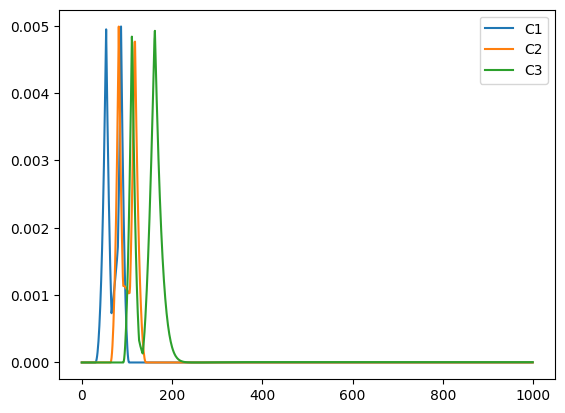

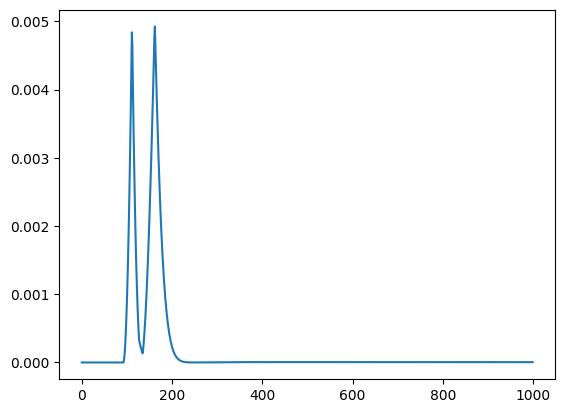

In [30]:
for i in range(C_cost.shape[1]):
    plt.plot(C_cost[:,i])
plt.legend(['C1', 'C2', 'C3'])
plt.show()

plt.plot(C_cost[:,2])

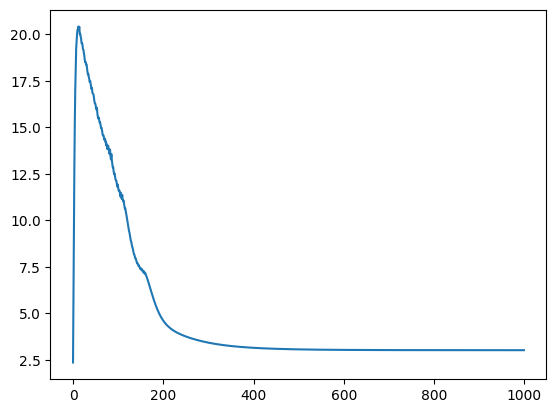

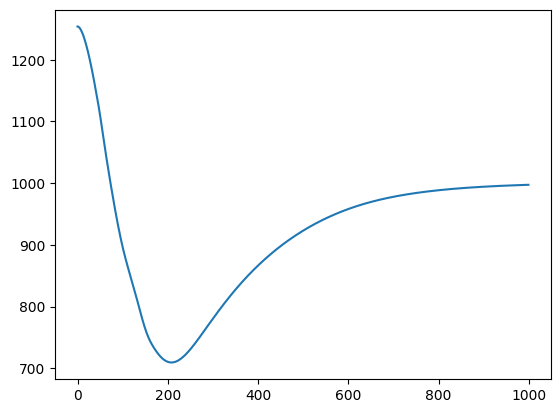

In [31]:
plt.plot(X_cost)
plt.show()

plt.plot(U_cost)
plt.show()

In [32]:
norm_err = np.linalg.norm(error_goal[:,:6],axis=1,ord=1)

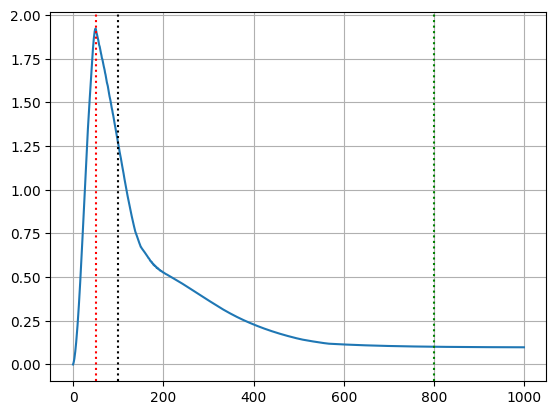

In [33]:
plt.plot(norm_err)
plt.grid(visible=True)
plt.axvline(x = sim_data['N_h'], color = 'r',linestyle = ':')
plt.axvline(x = corr_t_start, color = 'k',linestyle = ':')
plt.axvline(x = corr_t_end, color = 'g',linestyle = ':')
# plt.ylim([0,15])
plt.show()

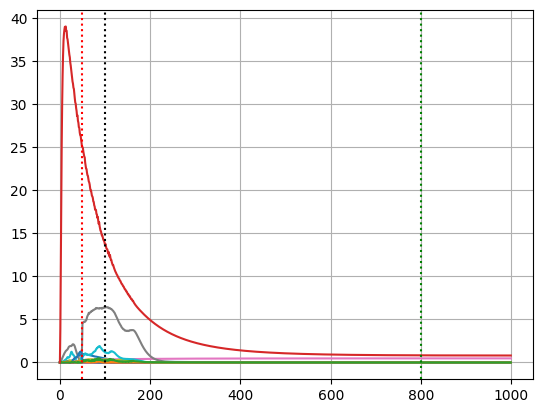

In [34]:
plt.plot(sqr_err[:,:])
plt.grid(visible=True)
plt.axvline(x = sim_data['N_h'], color = 'r',linestyle = ':')
plt.axvline(x = corr_t_start, color = 'k',linestyle = ':')
plt.axvline(x = corr_t_end, color = 'g',linestyle = ':')
plt.show()

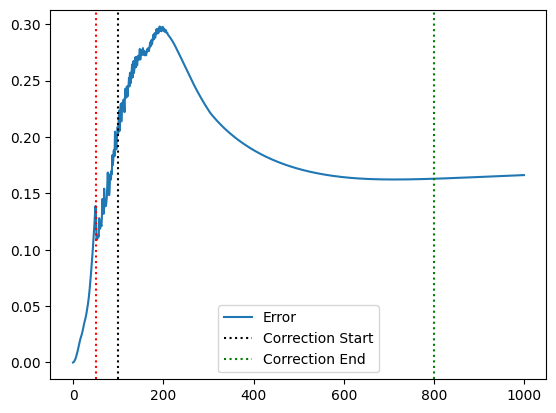

In [35]:
plt.plot(error_traj[:,4])
plt.axvline(x = corr_t_start, color = 'k',linestyle = ':')
plt.axvline(x = corr_t_end, color = 'g',linestyle = ':')
plt.axvline(x = sim_data['N_h'], color = 'r',linestyle = ':')
plt.legend(['Error', 'Correction Start','Correction End'])
plt.show()

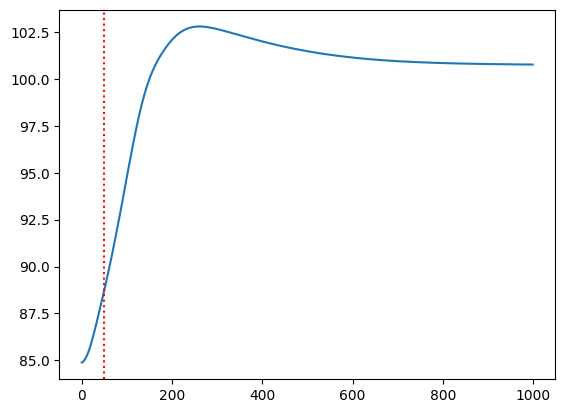

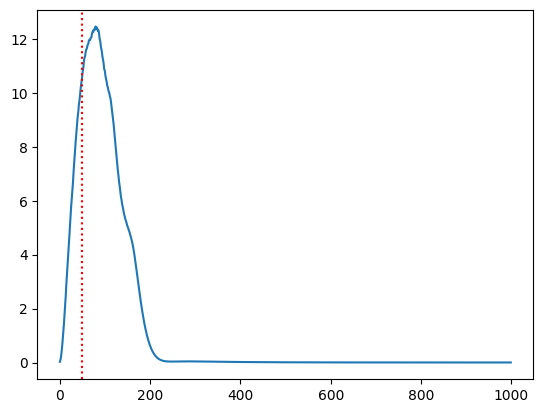

In [36]:
plt.plot(PE)
plt.axvline(x = sim_data['N_h'], color = 'r',linestyle = ':')
plt.show()

plt.plot(KE)
plt.axvline(x = sim_data['N_h'], color = 'r',linestyle = ':')
plt.show()

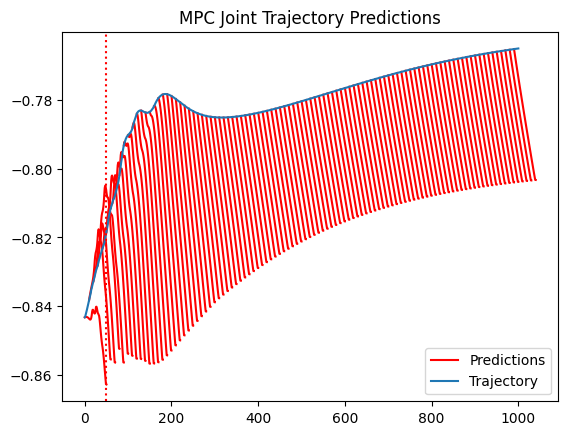

In [37]:
s_id = 4 # which state value to plot: [q, q_dot] from 0 to 13 

for i in range(mpc_cycle):
    if (i%10 == 0):
        t = np.linspace(i,i+T,T+1)
        if i == 0:
            plt.plot(t,sim_data['state_pred'][i,:,s_id],color='red')
        else:
            plt.plot(t,sim_data['state_pred'][i,:,s_id],color='red', label='_nolegend_')
plt.plot(sim_data['state_mea_SIM_RATE'][:,s_id])
if apply_correction:
    plt.axvline(x = corr_t_start, color = 'k',linestyle = ':')
    plt.axvline(x = corr_t_end, color = 'g',linestyle = ':')
    plt.legend(['Predictions', 'Trajectory','Correction Start','Correction End'])
else:
    plt.legend(['Predictions', 'Trajectory'])
plt.title('MPC Joint Trajectory Predictions')
plt.axvline(x = sim_data['N_h'], color = 'r',linestyle = ':')
plt.show()

diff_pred = []
for i in range(mpc_cycle-1):
    state_prev = sim_data['state_pred'][i,1:,s_id]
    state_curr = sim_data['state_pred'][i+1,:-1,s_id]
    diff_pred.append(np.linalg.norm(state_prev-state_curr))

# diff_pred = np.stack(diff_pred)
# plt.plot(diff_pred)
# if apply_correction:
#     plt.axvline(x = corr_t_start, color = 'k',linestyle = ':')
#     plt.axvline(x = corr_t_end, color = 'g',linestyle = ':')
#     plt.legend(['Consecutive Error','Correction Start','Correction End'])
# else:
#     plt.legend(['Consecutive Error'])
# plt.title('MPC Joint Trajectory Consecutive Error')
# plt.show()

# costs = np.stack(cost_hist)
# plt.plot(costs)
# if apply_correction:
#     plt.axvline(x = corr_t_start, color = 'k',linestyle = ':')
#     plt.axvline(x = corr_t_end, color = 'g',linestyle = ':')
#     plt.legend(['Cost','Correction Start','Correction End'])
# else:
#     plt.legend(['Cost'])
# plt.title('Cost History')
# plt.show()

In [38]:
sim_data['pose_pred'] = convert_2_cart(sim_data['state_pred'], endeff_frame_id)

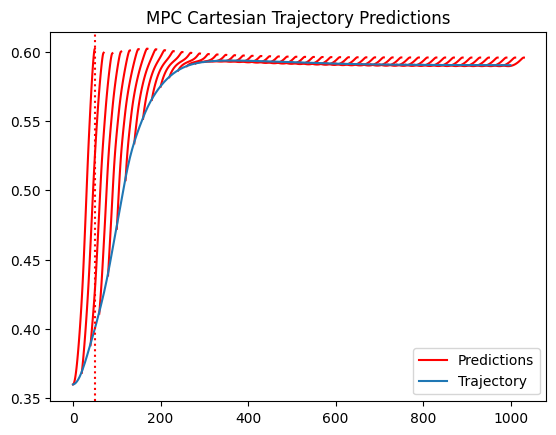

In [39]:
xyz = 2 # 0 for X, 1 for Y, and 2 for Z axes

pose_hist = np.vstack(pose)
for i in range(mpc_cycle):
    if (i%20 == 0):
        t = np.linspace(i,i+T,T+1)
        if i == 0:
            plt.plot(t,sim_data['pose_pred'][i,:,xyz],color='red')
        else:
            plt.plot(t,sim_data['pose_pred'][i,:,xyz],color='red',label='_nolegend_')
plt.plot(pose_hist[:,xyz])
if apply_correction:
    plt.axvline(x = corr_t_start, color = 'k',linestyle = ':')
    plt.axvline(x = corr_t_end, color = 'g',linestyle = ':')
    plt.legend(['Predictions', 'Trajectory','Correction Start','Correction End'])
else:
    plt.legend(['Predictions', 'Trajectory'])
plt.title('MPC Cartesian Trajectory Predictions')
plt.axvline(x = sim_data['N_h'], color = 'r',linestyle = ':')
plt.show()

# diff_pred_cart = []
# for i in range(mpc_cycle-1):
#     cart_prev = sim_data['pose_pred'][i,1:,xyz]
#     cart_curr = sim_data['pose_pred'][i+1,:-1,xyz]
#     diff_pred_cart.append(np.linalg.norm(cart_prev-cart_curr))
# diff_pred_cart = np.stack(diff_pred_cart)
# plt.plot(diff_pred_cart)
# if apply_correction:
#     plt.axvline(x = corr_t_start, color = 'k',linestyle = ':')
#     plt.axvline(x = corr_t_end, color = 'g',linestyle = ':')
#     plt.legend(['Consecutive Error','Correction Start','Correction End'])
# else:
#     plt.legend(['Consecutive Error'])
# plt.title('MPC Cartesian Trajectory Predictions Consecutive Error')
# plt.show()

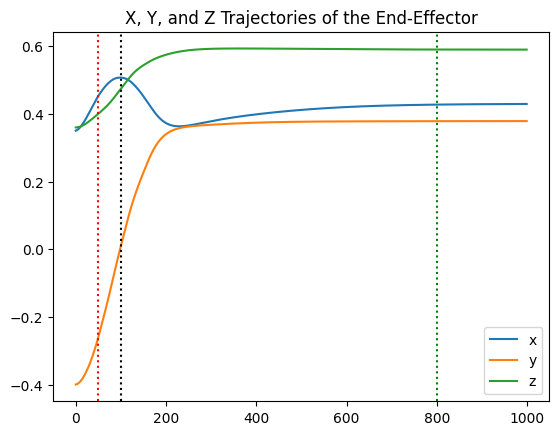

In [40]:
# Plot the X, Y, and Z trajectories of the end-effector
plt.plot(pose_hist)
plt.legend(['x', 'y', 'z'])
plt.axvline(x = corr_t_start, color = 'k',linestyle = ':')
plt.axvline(x = corr_t_end, color = 'g',linestyle = ':')
plt.axvline(x = sim_data['N_h'], color = 'r',linestyle = ':')
plt.title('X, Y, and Z Trajectories of the End-Effector')
plt.show()

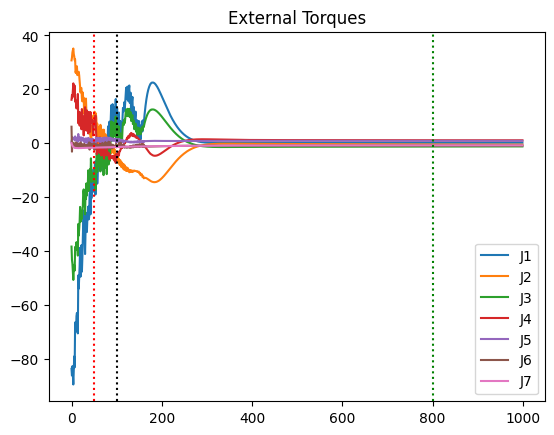

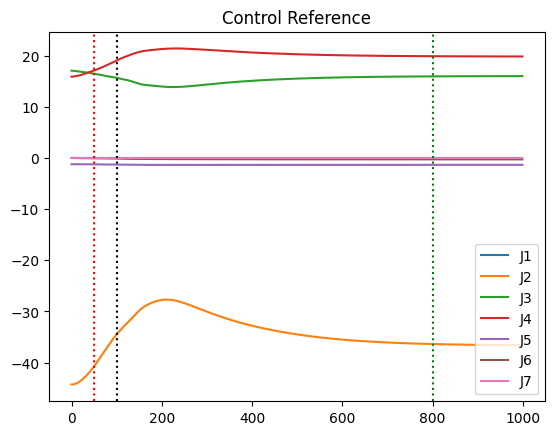

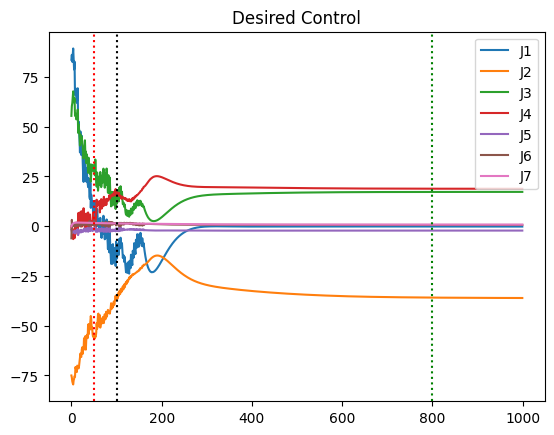

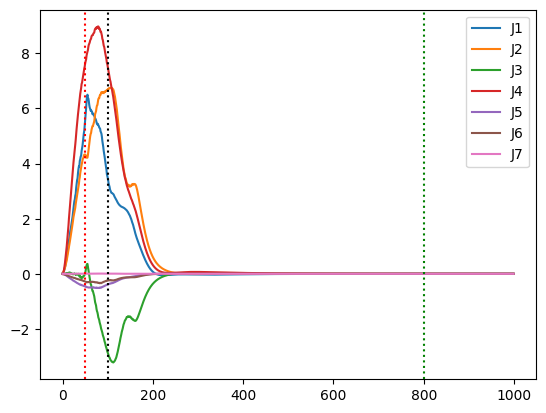

In [41]:
tau_ext = np.stack(tau_ext)
# External Torque Computed as: M*q_ddot + b - tau 
plt.plot(tau_ext)
plt.axvline(x = corr_t_start, color = 'k',linestyle = ':')
plt.axvline(x = corr_t_end, color = 'g',linestyle = ':')
plt.legend(['J1','J2','J3','J4','J5','J6','J7'])
plt.title('External Torques')
plt.axvline(x = sim_data['N_h'], color = 'r',linestyle = ':')
plt.show()

# Control Reference
plt.plot(sim_data['ctrl_ref'])
plt.axvline(x = corr_t_start, color = 'k',linestyle = ':')
plt.axvline(x = corr_t_end, color = 'g',linestyle = ':')
plt.legend(['J1','J2','J3','J4','J5','J6','J7'])
plt.title('Control Reference')
plt.axvline(x = sim_data['N_h'], color = 'r',linestyle = ':')
plt.show()

# Desired Control
plt.plot(sim_data['ctrl_des_SIM_RATE'])
plt.axvline(x = corr_t_start, color = 'k',linestyle = ':')
plt.axvline(x = corr_t_end, color = 'g',linestyle = ':')
plt.legend(['J1','J2','J3','J4','J5','J6','J7'])
plt.title('Desired Control')
plt.axvline(x = sim_data['N_h'], color = 'r',linestyle = ':')
plt.show()

plt.plot(sim_data['ctrl_ref'] - sim_data['ctrl_des_SIM_RATE'] - tau_ext)
plt.axvline(x = corr_t_start, color = 'k',linestyle = ':')
plt.axvline(x = corr_t_end, color = 'g',linestyle = ':')
plt.legend(['J1','J2','J3','J4','J5','J6','J7'])
plt.axvline(x = sim_data['N_h'], color = 'r',linestyle = ':')
plt.show()

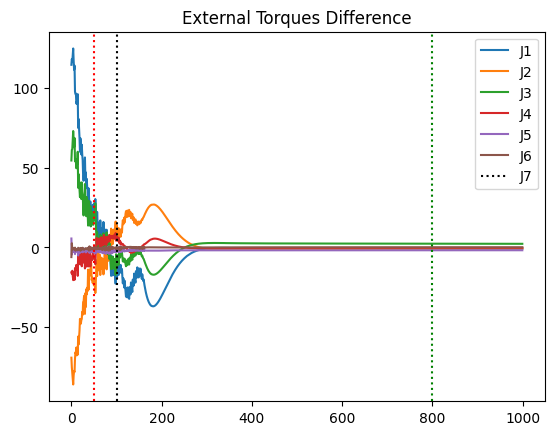

In [42]:
plt.plot(np.diff(tau_ext))
plt.axvline(x = corr_t_start, color = 'k',linestyle = ':')
plt.axvline(x = corr_t_end, color = 'g',linestyle = ':')
plt.legend(['J1','J2','J3','J4','J5','J6','J7'])
plt.title('External Torques Difference')
plt.axvline(x = sim_data['N_h'], color = 'r',linestyle = ':')
plt.show()

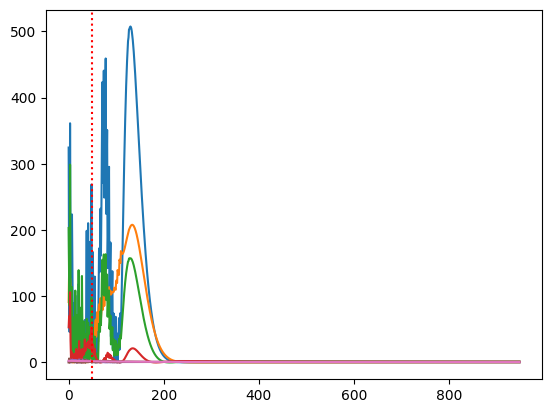

8498.50929764197


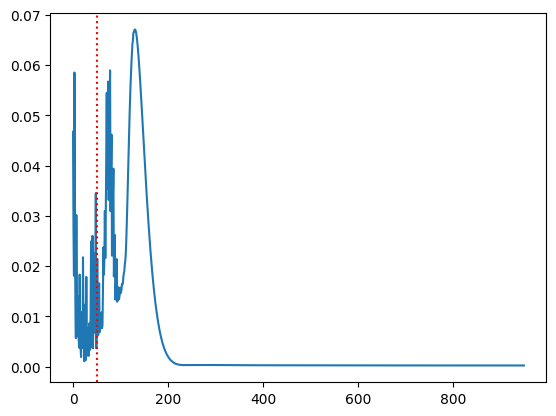

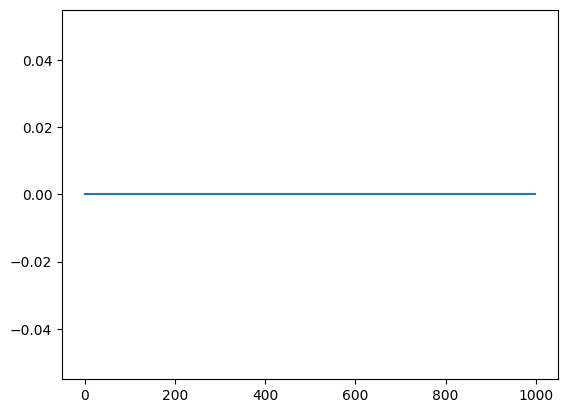

In [43]:
tau_sqr = tau_ext**2
# tau_sqr = tau_sqr/(np.max(tau_sqr[:sim_data['N_h']]))
plt.plot(tau_sqr[sim_data['N_h']:])
plt.axvline(x = sim_data['N_h'], color = 'r',linestyle = ':')
plt.show()

tau_norm = np.linalg.norm(tau_sqr,axis=1)
print(np.max(tau_norm[:sim_data['N_h']]))
tau_norm = tau_norm/(np.max(tau_norm[:sim_data['N_h']]))
plt.plot(tau_norm[sim_data['N_h']:])
plt.axvline(x = sim_data['N_h'], color = 'r',linestyle = ':')
plt.show()

plt.plot(pert)

In [44]:
if Mujoco_view:
    pert = np.stack(pert)
# div = np.stack(div)
# div_q = np.stack(div_q)
# div_v = np.stack(div_v)